In [68]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [69]:
import torch # for tensor operations
import torchvision  # for CIFAR dataset
import torchvision.transforms as transforms # for data augmentation

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info" style="background-color: #aa96da"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [70]:
transform = transforms.Compose( # Compose several transforms together
    [transforms.ToTensor(),# Convert PIL image to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize to [-1,1]

batch_size = 4 # Number of images per batch

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) # Download training data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2) # Create dataloader

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Class names

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



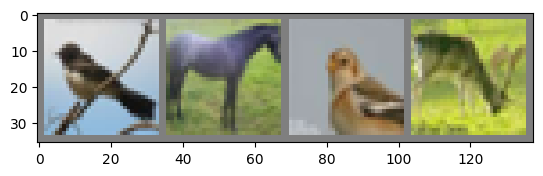

bird         horse        bird         deer 


In [71]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader) # Create an iterator
images, labels = next(dataiter) # Get the next batch

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('        '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [72]:
images.shape

torch.Size([4, 3, 32, 32])

In [73]:
labels

tensor([2, 7, 2, 4])

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [74]:
import torch.nn as nn # for neural networks
import torch.nn.functional as F # for activation functions


class Net(nn.Module): # Define a neural network
    def __init__(self): # Constructor
        super().__init__()
        # Define layers(Unmodified)
        # self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        # self.pool = nn.MaxPool2d(2, 2) # 2x2 pooling with stride 2
        # self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel
        # self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16*5*5 input features, 120 output features
        # self.fc2 = nn.Linear(120, 84)  # 120 input features, 84 output features
        # self.fc3 = nn.Linear(84, 10) # 84 input features, 10 output features
        # Define layers(20 feature maps with 3X3 kernel)
        #self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 20, 3)
        # self.fc1 = nn.Linear(20 * 6 * 6, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)
        # Define layers(60 feature maps with 2X2 kernel)
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 60, 2)
        # self.fc1 = nn.Linear(60 * 6 * 6, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)
        # Define layers(60 feature maps with 3X3 kernel)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 60, 3)
        self.fc1 = nn.Linear(60 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        

    def forward(self, x): # Forward pass
        x = self.pool(F.relu(self.conv1(x))) # Apply convolution, then ReLU, then pooling
        x = self.pool(F.relu(self.conv2(x))) # Apply convolution, then ReLU, then pooling
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # Apply ReLU
        x = F.relu(self.fc2(x)) # Apply ReLU
        x = self.fc3(x) # Apply linear layer
        return x


net = Net() # Create an instance of the network class

In [75]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 60, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2160, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [76]:
from torchvision import models # for pretrained models
from torchsummary import summary # for model summary
summary(net, (3, 32, 32)) # Print model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 60, 12, 12]           3,300
         MaxPool2d-4             [-1, 60, 6, 6]               0
            Linear-5                  [-1, 120]         259,320
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 274,090
Trainable params: 274,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.13
Params size (MB): 1.05
Estimated Total Size (MB): 1.19
----------------------------------------------------------------


### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [77]:
import torch.optim as optim # for optimizers

criterion = nn.CrossEntropyLoss() # Define loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Define optimizer

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [78]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0 # Initialize running loss
    for i, data in enumerate(trainloader, 0): # Iterate over batches
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backward pass
        optimizer.step() # Optimize

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.150
[1,  4000] loss: 1.758
[1,  6000] loss: 1.582
[1,  8000] loss: 1.487
[1, 10000] loss: 1.410
[1, 12000] loss: 1.362
[2,  2000] loss: 1.255
[2,  4000] loss: 1.227
[2,  6000] loss: 1.196
[2,  8000] loss: 1.168
[2, 10000] loss: 1.143
[2, 12000] loss: 1.131
[3,  2000] loss: 1.028
[3,  4000] loss: 1.039
[3,  6000] loss: 1.017
[3,  8000] loss: 1.011
[3, 10000] loss: 1.011
[3, 12000] loss: 0.997
[4,  2000] loss: 0.870
[4,  4000] loss: 0.898
[4,  6000] loss: 0.902
[4,  8000] loss: 0.898
[4, 10000] loss: 0.880
[4, 12000] loss: 0.897
[5,  2000] loss: 0.744
[5,  4000] loss: 0.763
[5,  6000] loss: 0.782
[5,  8000] loss: 0.791
[5, 10000] loss: 0.797
[5, 12000] loss: 0.793
[6,  2000] loss: 0.620
[6,  4000] loss: 0.674
[6,  6000] loss: 0.685
[6,  8000] loss: 0.696
[6, 10000] loss: 0.718
[6, 12000] loss: 0.714
[7,  2000] loss: 0.538
[7,  4000] loss: 0.569
[7,  6000] loss: 0.602
[7,  8000] loss: 0.584
[7, 10000] loss: 0.628
[7, 12000] loss: 0.643
[8,  2000] loss: 0.456
[8,  4000] 

Let's quickly save our trained model:



In [79]:
PATH = './cifar_net_3.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



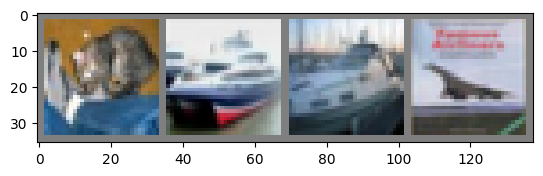

GroundTruth:  cat   ship  ship  plane


In [80]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [81]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [82]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [83]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [84]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [85]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.2 %
Accuracy for class: car   is 73.6 %
Accuracy for class: bird  is 50.9 %
Accuracy for class: cat   is 48.5 %
Accuracy for class: deer  is 44.8 %
Accuracy for class: dog   is 58.6 %
Accuracy for class: frog  is 79.1 %
Accuracy for class: horse is 67.2 %
Accuracy for class: ship  is 75.0 %
Accuracy for class: truck is 74.8 %


## Unmodified model
Accuracy for class: plane is 61.2 %<br>
Accuracy for class: car   is 81.1 %<br>
Accuracy for class: bird  is 43.5 %<br>
Accuracy for class: cat   is 36.7 %<br>
Accuracy for class: deer  is 58.3 %<br>
Accuracy for class: dog   is 61.9 %<br>
Accuracy for class: frog  is 69.6 %<br>
Accuracy for class: horse is 67.2 %<br>
Accuracy for class: ship  is 80.0 %<br>
Accuracy for class: truck is 68.4 %<br>

## 20 feature maps with kernel 3x3
Accuracy for class: plane is 72.0 %<br>
Accuracy for class: car   is 68.5 %<br>
Accuracy for class: bird  is 51.4 %<br>
Accuracy for class: cat   is 49.3 %<br>
Accuracy for class: deer  is 58.0 %<br>
Accuracy for class: dog   is 39.5 %<br>
Accuracy for class: frog  is 75.6 %<br>
Accuracy for class: horse is 76.0 %<br>
Accuracy for class: ship  is 74.2 %<br>
Accuracy for class: truck is 64.7 %<br>

## 60 feature maps with kernel 2x2
Accuracy for class: plane is 69.7 %<br>
Accuracy for class: car   is 78.3 %<br>
Accuracy for class: bird  is 51.3 %<br>
Accuracy for class: cat   is 44.3 %<br>
Accuracy for class: deer  is 66.2 %<br>
Accuracy for class: dog   is 47.4 %<br>
Accuracy for class: frog  is 60.0 %<br>
Accuracy for class: horse is 67.2 %<br>
Accuracy for class: ship  is 71.0 %<br>
Accuracy for class: truck is 71.5 %<br>

## 60 feature maps with kernel 3x3
Accuracy for class: plane is 65.2 %<br>
Accuracy for class: car   is 73.6 %<br>
Accuracy for class: bird  is 50.9 %<br>
Accuracy for class: cat   is 48.5 %<br>
Accuracy for class: deer  is 44.8 %<br>
Accuracy for class: dog   is 58.6 %<br>
Accuracy for class: frog  is 79.1 %<br>
Accuracy for class: horse is 67.2 %<br>
Accuracy for class: ship  is 75.0 %<br>
Accuracy for class: truck is 74.8 %<br>

Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [86]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [87]:
#del dataiter